# Acquisition de la Mire

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import math as m
import glob
frame_nb = 0

## Acquisition

In [2]:
# cap = cv2.VideoCapture(0)
# while(True):
#     ret, frame = cap.read() #1 frame acquise à chaque iteration
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #conversion en n&b
#     cv2.imshow('Capture_Video', gray) #affichage
#     key = cv2.waitKey(1) #on évalue la touche pressée
#     # if (key & 0xFF == ord('c')): #si appui sur'q'
#     #     cv2.imwrite("capture%d.jpg" % frame_nb, gray)
#     #     frame_nb += 1
#     if key & 0xFF == ord('q'): #si appui sur'q'
#         break #sortie de la boucle while
# cap.release()
# cv2.destroyAllWindows()

Grace à ce code nous pouvons communiquer avec la webcam, et accéder au flux vidéo. En appuyant sur la touche C il est possible d'effectuer une capture d'écran et Q permet de quitter le programme

## Detection depuis capture

In [3]:
img0 = cv2.imread('./capture_mire_0.png')
img1 = cv2.imread('./capture_mire_1.png')

In [148]:
# images = images = glob.glob('*.png')
images = [img0,img1]
n = 7
corners =[]

for img in images:
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    corners.append(cv2.findChessboardCorners(gray, (n,n), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)[1])

N = n*n*2
corners = np.array(corners).reshape(N,2)

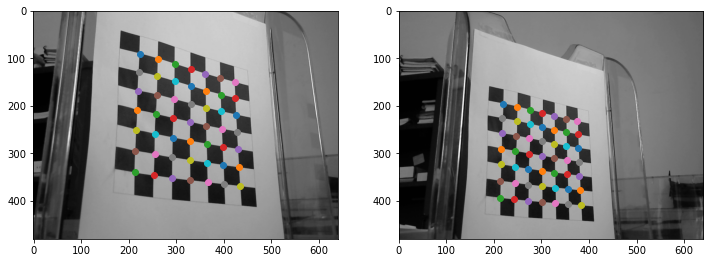

In [162]:
f, axarr = plt.subplots(1,2,figsize=(12,12))

axarr[0].imshow(img0)
for point in corners[:49]:
    axarr[0].scatter(point[0],point[1])
axarr[1].imshow(img1)
for point in corners[49:]:
    axarr[1].scatter(point[0],point[1])

## Création des Vecteurs

In [8]:
coord_px = corners
coord_mm=[]
x = np.linspace(0,120,7)
y = np.linspace(0,120,7)
for ord in y:
    for abs in x:
        coord_mm.append([abs,ord])
coord_mm = np.array(coord_mm)
coord_mm = np.concatenate((coord_mm,coord_mm))
coord_mm = np.concatenate((coord_mm,np.zeros((N,1))),axis=1)
coord_mm[int(N/2):int(N),2]= 120

# Calibrage de la caméra

## Implémentation de la méthode Tsai

### Estimation du vecteur intermédiaire L

In [9]:
i1 = gray.shape[0]/2
i2 = gray.shape[1]/2

In [10]:
U1 = np.array([x[0]-i1 for x in coord_px]).reshape(N,1)
U2 = np.array([x[1]-i2 for x in coord_px]).reshape(N,1)

In [11]:
x1 = coord_mm[:,0].reshape(N,1)
x2 = coord_mm[:,1].reshape(N,1)
x3 = coord_mm[:,2].reshape(N,1)

one=np.ones((N,1))

In [12]:
A = np.concatenate([U2*x1,U2*x2,U2*x3,U2,-x1*U1,-x2*U1,-x3*U1],axis=1)

In [13]:
L = np.dot(np.linalg.pinv(A),U1)
L=L.reshape(7,)
L

array([-0.00828362,  0.00030321,  0.00042017,  0.0725595 , -0.00117032,
       -0.00903092, -0.00249147])

### Résolution analytique

In [14]:
oc2 = -1/np.sqrt(np.square(L[4]) + np.square(L[5]) + np.square(L[6]))
beta = np.abs(oc2)*np.sqrt(np.square(L[0]) + np.square(L[1]) + np.square(L[2]))
oc1 = oc2*L[3]/beta

r11 = L[0]*oc2/beta
r12 = L[1]*oc2/beta
r13 = L[2]*oc2/beta

r21 = L[4]*oc2
r22 = L[5]*oc2
r23 = L[6]*oc2

print(" beta =",beta,'\n')
print(" oc1 =", oc1, "\n", "oc2 =",oc2,'\n')
print(" r11 =", r11, "\n", "r12 =", r12, "\n","r13 =", r13,'\n') 
print(" r21 =", r21, "\n", "r22 =", r22, "\n","r23 =", r23,'\n')

 beta = 0.8791134085953666 

 oc1 = -8.742309218143628 
 oc2 = -105.91970874012817 

 r11 = 0.9980494002538751 
 r12 = -0.03653220889795934 
 r13 = -0.050624029530609946 

 r21 = 0.12396033338360084 
 r22 = 0.9565526817570792 
 r23 = 0.26389543908670826 



In [15]:
r3 = np.cross(np.array((r11, r12, r13)).transpose(),np.array((r21 ,r22, r23)).transpose())

r31 = r3[0]
r32 = r3[1]
r33 = r3[2]

print(" r31 =", r31, "\n", "r32 =", r32, "\n", "r33 =", r33,'\n')

 r31 = 0.038783867900920185 
 r32 = -0.26965605628805783 
 r33 = 0.9592153751331192 



In [16]:
phi = -np.arctan(r23/r33)
gamma = -np.arctan(r12/r11)
omega = np.arctan(r13/(-r23*np.sin(phi)+r33*np.cos(phi)))

print("phi   =",phi*180/np.pi)
print("gamma =",gamma*180/np.pi)
print("omega =",omega*180/np.pi)

phi   = -15.382426863522454
gamma = 2.0962963582956755
omega = -2.913033387749528


### Estimation du vecteur M

In [17]:
B = -(r21*x1 + r22*x2 + r23*x3 +oc2*one)
B = np.concatenate((U2*one, B), axis=1)

In [18]:
R = -U2*(r31*x1 + r32*x2 + r33*x3)


In [26]:
oc3,f2 = np.dot(np.linalg.pinv(B),R)
oc3 = oc3[0]
f2 = f2[0]

In [27]:
f = 4.4
s2 = f/f2
s1 = s2/beta
f1 = f/s1

In [28]:
print(" beta =", beta, "\n")
print(" oc1 =", oc1, "\n", "oc2 =", oc2, "\n", "oc3 =", oc3, "\n")
print(" r11 =", r11, "\n", "r12 =", r12, "\n","r13 =", r13, "\n")
print(" r21 =", r21, "\n", "r22 =", r22, "\n","r23 =", r23, "\n") 
print(" r31 =", r31, "\n", "r32 =", r32, "\n","r33 =", r33, "\n") 
print(" s1 =", s1, "\n","s2 =", s2)

 beta = 0.8791134085953666 

 oc1 = -8.742309218143628 
 oc2 = -105.91970874012817 
 oc3 = 337.13285151261374 

 r11 = 0.9980494002538751 
 r12 = -0.03653220889795934 
 r13 = -0.050624029530609946 

 r21 = 0.12396033338360084 
 r22 = 0.9565526817570792 
 r23 = 0.26389543908670826 

 r31 = 0.038783867900920185 
 r32 = -0.26965605628805783 
 r33 = 0.9592153751331192 

 s1 = 0.00717916832982626 
 s2 = 0.006311303141313468


In [73]:
M_int = np.array([f1,0,i1,0,
            0,f2,i2,0,
            0,0,1,0],float).reshape(3,4)

M_ext = np.array([r11,r12,r13,oc1,
        r21,r22,r23,oc2,
        r31,r32,r33,oc3,
        0,0,0,1],float).reshape(4,4)

M = np.dot(M_int,M_ext)

X = np.array([x1.reshape(N,),x2.reshape(N,),x3.reshape(N,),1])

alpha_u1,alpha_u2,alpha = np.dot(M,X)

u1 = alpha_u1/alpha
u2 = alpha_u2/alpha

c:\users\matmo\.venvs\medgo\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


array([[612.88436179,   0.        , 240.        ,   0.        ],
       [  0.        , 697.16188582, 320.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

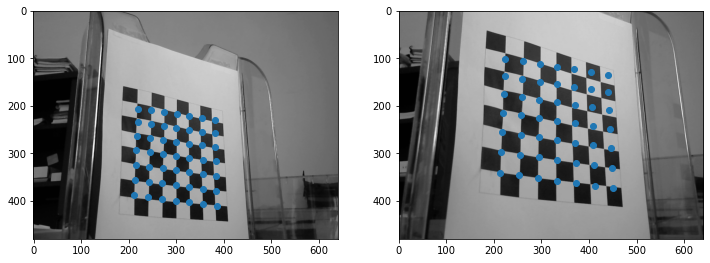

In [166]:
f, axarr = plt.subplots(1,2,figsize=(12,12))

axarr[1].imshow(img0)
axarr[1].scatter(u1[:49],u2[:49])
axarr[0].imshow(img1)
axarr[0].scatter(u1[49:],u2[49:])

# QUESTION SUBSIDIAIRE

In [68]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('*.png')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,7), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (7,7), corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

In [109]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [132]:
dist

array([[ 0.48381876, -6.40560826, -0.04208192,  0.0453009 , 31.57823003]])

In [127]:
M_int2 = np.append(mtx,np.array([0,0,0]).reshape(3,1),axis=1)
rvecs = np.array(rvecs).reshape(2,3)
r3_new = np.cross(rvecs[0],rvecs[1]).reshape(1,3)
r3_new = np.append(rvecs,r3_new,axis=0)
m_ext2 = np.append(r3_new,[0,0,0])

array([[-0.37694479, -0.5489979 ,  0.11145703],
       [-0.36625948, -0.58202503,  0.11309691],
       [ 0.00278082,  0.00180909,  0.01831561]])

In [125]:
rvecs

array([[-0.37694479, -0.5489979 ,  0.11145703],
       [-0.36625948, -0.58202503,  0.11309691]])

In [124]:
r3_new

array([0.00278082, 0.00180909, 0.01831561])